In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set_style('whitegrid')

In [2]:
transformer_train = torchvision.transforms.Compose([
    #torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    #torchvision.transforms.RandomRotation(degrees=15),
    torchvision.transforms.RandomAffine(0, translate=(0.1, 0.1)),
    #torchvision.transforms.RandomPerspective(),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='.', train=True, transform=transformer_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='.', train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# behaves differently from MNIST / Fashion MNIST
# it is a NumPy array, not a PyTorch tensor
train_dataset.data

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [4]:
# we are working with color images now!
train_dataset.data.shape

(50000, 32, 32, 3)

In [5]:
# behaves differently from MNIST / Fashion MNIST
# it is a list!
train_dataset.targets

[6,
 9,
 9,
 4,
 1,
 1,
 2,
 7,
 8,
 3,
 4,
 7,
 7,
 2,
 9,
 9,
 9,
 3,
 2,
 6,
 4,
 3,
 6,
 6,
 2,
 6,
 3,
 5,
 4,
 0,
 0,
 9,
 1,
 3,
 4,
 0,
 3,
 7,
 3,
 3,
 5,
 2,
 2,
 7,
 1,
 1,
 1,
 2,
 2,
 0,
 9,
 5,
 7,
 9,
 2,
 2,
 5,
 2,
 4,
 3,
 1,
 1,
 8,
 2,
 1,
 1,
 4,
 9,
 7,
 8,
 5,
 9,
 6,
 7,
 3,
 1,
 9,
 0,
 3,
 1,
 3,
 5,
 4,
 5,
 7,
 7,
 4,
 7,
 9,
 4,
 2,
 3,
 8,
 0,
 1,
 6,
 1,
 1,
 4,
 1,
 8,
 3,
 9,
 6,
 6,
 1,
 8,
 5,
 2,
 9,
 9,
 8,
 1,
 7,
 7,
 0,
 0,
 6,
 9,
 1,
 2,
 2,
 9,
 2,
 6,
 6,
 1,
 9,
 5,
 0,
 4,
 7,
 6,
 7,
 1,
 8,
 1,
 1,
 2,
 8,
 1,
 3,
 3,
 6,
 2,
 4,
 9,
 9,
 5,
 4,
 3,
 6,
 7,
 4,
 6,
 8,
 5,
 5,
 4,
 3,
 1,
 8,
 4,
 7,
 6,
 0,
 9,
 5,
 1,
 3,
 8,
 2,
 7,
 5,
 3,
 4,
 1,
 5,
 7,
 0,
 4,
 7,
 5,
 5,
 1,
 0,
 9,
 6,
 9,
 0,
 8,
 7,
 8,
 8,
 2,
 5,
 2,
 3,
 5,
 0,
 6,
 1,
 9,
 3,
 6,
 9,
 1,
 3,
 9,
 6,
 6,
 7,
 1,
 0,
 9,
 5,
 8,
 5,
 2,
 9,
 0,
 8,
 8,
 0,
 6,
 9,
 1,
 1,
 6,
 3,
 7,
 6,
 6,
 0,
 6,
 6,
 1,
 7,
 1,
 5,
 8,
 3,
 6,
 6,
 8,
 6,
 8,
 4,
 6,
 6,


In [6]:
# number of classes
K = len(set(train_dataset.targets))
print('number of classes: ', K)

number of classes:  10


In [7]:
# Data Loader
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
# Define the model
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        
        # define the conv layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )
        
        # MaxPool2D
        # H_out = H_in + 2p - 2  ===>  p = 1 if H_out = H_in
        
        # define the linear layers
        self.fc1 = nn.Linear(128*4*4, 1024)
        self.fc2 = nn.Linear(1024, K)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2)
        x = self.fc2(x)
        return x

In [15]:
# Instantiate the model
model = CNN(K)

In [16]:
device = torch.device('cuda:0')
print(device)
model.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [17]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [18]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for i in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # backward and optimize
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
        # Get train loss and test loss
        train_loss = np.mean(train_losses)
        
        test_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)
        
        # Save losses
        train_losses[i] = train_loss
        test_losses[i] = test_loss
        
        dt = datetime.now() - t0
        print(f'Epoch {i+1}/{epochs}, Train Loss: {train_loss:.4f}, \ Test Loss: {test_loss:.4f}, Duration: {dt}')
    
    return train_losses, test_losses

In [19]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=80)

Epoch 1/80, Train Loss: 0.0000, \ Test Loss: 1.1743, Duration: 0:02:50.585872
Epoch 2/80, Train Loss: 0.0000, \ Test Loss: 0.9058, Duration: 0:02:43.194699
Epoch 3/80, Train Loss: 0.0000, \ Test Loss: 0.7797, Duration: 0:02:49.557647
Epoch 4/80, Train Loss: 0.0000, \ Test Loss: 0.7150, Duration: 0:02:57.574509
Epoch 5/80, Train Loss: 0.0000, \ Test Loss: 0.6413, Duration: 0:02:54.339314
Epoch 6/80, Train Loss: 0.0000, \ Test Loss: 0.6150, Duration: 0:03:05.689932
Epoch 7/80, Train Loss: 0.0000, \ Test Loss: 0.5560, Duration: 0:02:58.415008
Epoch 8/80, Train Loss: 0.0000, \ Test Loss: 0.5521, Duration: 0:02:57.735278
Epoch 9/80, Train Loss: 0.0000, \ Test Loss: 0.4949, Duration: 0:04:00.075072
Epoch 10/80, Train Loss: 0.0000, \ Test Loss: 0.5080, Duration: 0:04:43.665805
Epoch 11/80, Train Loss: 0.0000, \ Test Loss: 0.4823, Duration: 0:01:25.533796
Epoch 12/80, Train Loss: 0.0000, \ Test Loss: 0.4629, Duration: 0:01:24.571239
Epoch 13/80, Train Loss: 0.0000, \ Test Loss: 0.4445, Duratio

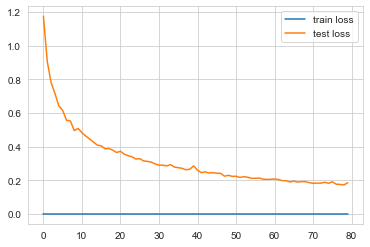

In [20]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

In [21]:
# Accuracy
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    
    # forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
    
    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    
    # forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
    
    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f'Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}')

Train accuracy: 0.9352, Test accuracy: 0.8715


In [22]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Confusion Matrix is Normalized')
    else:
        print('Confusion Matrix was normalized before')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

Confusion Matrix was normalized before
[[864  11  17  16  16   4   5   7  43  17]
 [ 10 950   0   2   0   0   2   1   3  32]
 [ 47   3 769  38  40  25  59  12   5   2]
 [ 21   6  19 766  35  83  30  21  11   8]
 [  5   1  17  31 885  18  25  14   3   1]
 [  4   2  24 109  24 792  12  29   1   3]
 [  8   1  12  28  13   8 922   5   1   2]
 [  9   3   7  21  26  22   8 900   0   4]
 [ 37  20   2   4   0   1   3   1 918  14]
 [ 22  47   1   5   0   0   6   2   9 908]]


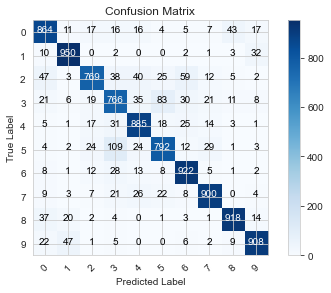

In [23]:
# get all predictions in an array and plot confusion matrix
x_test = test_dataset.data
y_test = test_dataset.targets
p_test = np.array([])
for inputs, targets in test_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    
    # forward pass
    outputs = model(inputs)
    
    # Get prediction
    _, predictions = torch.max(outputs, 1)
    
    # update p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))
    
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [24]:
# Label mapping
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split('\n')

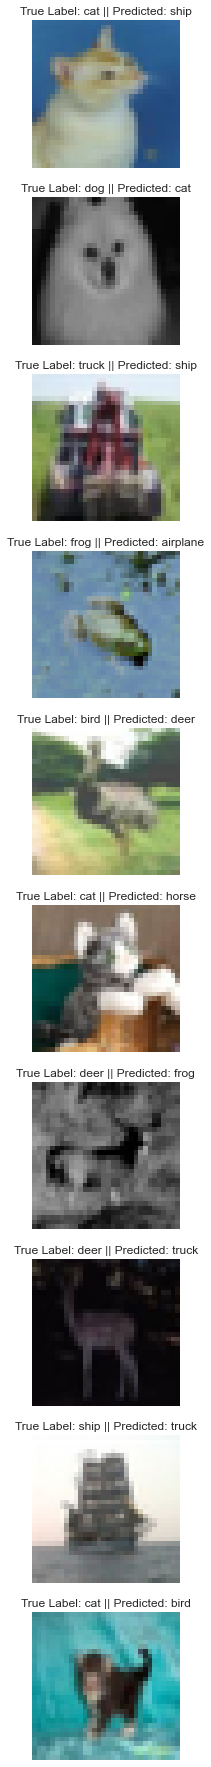

In [26]:
# Show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
sample_idx = np.random.choice(misclassified_idx, 10, replace=True)
plt.figure(figsize=(32,32))
for j, i in enumerate(sample_idx):
    plt.subplot(10, 1, j+1)
    plt.axis('off')
    plt.imshow(x_test[i].reshape(32,32,3))
    plt.title('True Label: %s || Predicted: %s' % (labels[y_test[i]], labels[p_test[i]]))

In [28]:
from torchsummary import summary
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
              ReLU-9           [-1, 64, 16, 16]               0
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11           [-1, 64, 16, 16]          36,928
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
        MaxPool2d-14             [-1, 6